In [26]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def load_image(image_path):
    return mpimg.imread(image_path)

def save_plot(dir_name, name, img):
    cv2.imwrite(join(dir_name, name), img)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_noise(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = (255,)

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=(255, 0, 0), thickness=1):
    left_slope = [0]
    right_slope = [0]
    left_lines=[0]
    right_lines = [0]
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y1-y2)/(x1-x2)) # slope
            if m <= -0.2:
                left_slope.append(m)
                left_lines.append((x1,y1))
            elif m >= 0.2 and m <= 0.88:
                right_slope.append(m)
                right_lines.append((x2,y2))

    # average left and right slopes
    right_slope = sorted(right_slope)[int(len(right_slope)/2)]
    left_slope = sorted(left_slope)[int(len(left_slope)/2)]
    
    start_left_y = sorted([line[1] for line in left_lines])[int(len(left_lines)/2)]
    start_left_x = [line[0] for line in left_lines if line[1] == start_left_y][0]

    start_right_y = sorted([line[1] for line in right_lines])[int(len(right_lines)/2)]
    start_right_x = [line[0] for line in right_lines if line[1] == start_right_y][0]

    # next we extend to the car
    end_left_x = int((img.shape[1]-start_left_y)/left_slope) + start_left_x
    end_right_x = int((img.shape[1]-start_right_y)/right_slope) + start_right_x
    
    cv2.line(img, (start_left_x, start_left_y), (end_left_x, img.shape[1]), color, thickness)
    cv2.line(img, (start_right_x, start_right_y), (end_right_x, img.shape[1]), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold,
                            np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(edges, line_img, alpha=0.8, beta=1., upsilon=0.):
    color_edges = np.dstack((edges, edges, edges))
    return cv2.addWeighted(color_edges, alpha, line_img, beta, upsilon)


def process_image(img):
    dir_name = "output_images"
    line_image = np.copy(img)*0

    gray_img = grayscale(img)
    blur_gray = gaussian_noise(gray_img, 5)
    edges = canny(blur_gray, 50, 150)

    imshape = img.shape
    vertices = np.array([[(110,imshape[0]),(410, 310),(480, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    lines = hough_lines(masked_edges, .1, np.pi/180, 15, 120, 80)
    final_img = weighted_img(lines, image)
    #save_plot(dir_name, "final_"+name, final_img)
    return final_img


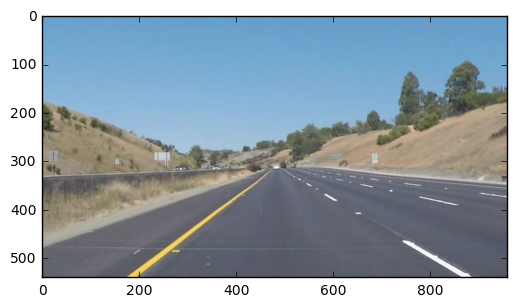

In [27]:
    #image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
    #plt.imshow(process_image(image))
    #plt.show() 
